First, we want to load data. Data is generally stored in CSV files which are based on elevation and chainage (distance) and height of the pipeline. Other fields will be in this sort of data but let's use these two fields to start.

I also imported a few packages such as seaborn, numpy, pandas and matplotlib to aid in reducing the number of packages.



In [40]:
#importing the packages
 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas.util.testing as tm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
#importing the data
path = 'https://raw.githubusercontent.com/thomasgnyra/climbingdata/master/elevationdata.csv'
df = pd.read_csv(path)
 
df.head()

,Chainage,Elevation
0,32001.1,683.2
1,32002.1,683.2
2,32003.1,683.2
3,32004.1,683.2
4,32005.1,683.2


We can see the top five fields here and the two headers. Now we should add another column to find elevation differences and chainage differences. 

In [41]:
df['Chainage delta'] = df['Chainage'] - df['Chainage'].shift(1) 
df['Elevation delta'] = df['Elevation'] - df['Elevation'].shift(1)
df.head()

,Chainage,Elevation,Chainage delta,Elevation delta
0,32001.1,683.2,NaN,NaN
1,32002.1,683.2,1.0,0.0
2,32003.1,683.2,1.0,0.0
3,32004.1,683.2,1.0,0.0
4,32005.1,683.2,1.0,0.0


Let's actually just output a graph to see what it looks like right now. Below is the chainage and elevation graphs of the pipeline. This is what a 2D cut of the pipeline would look like. 

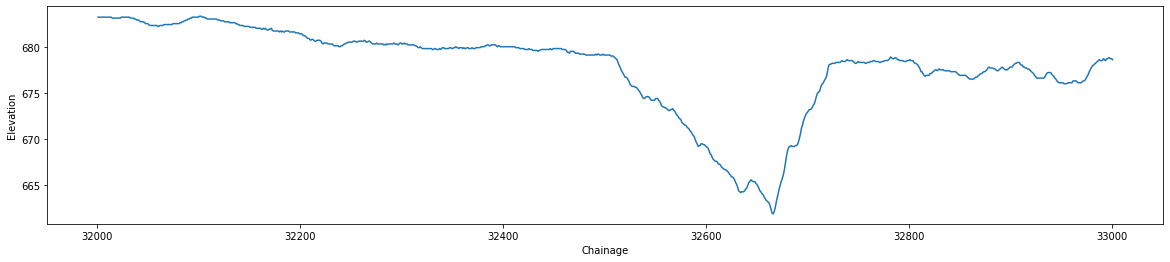

In [42]:
plt.figure(figsize=(20,4))
sns.lineplot(x="Chainage", y="Elevation", data=df)

So now that we have some chainage and elevation deltas, we can go ahead and use the distance formula. Due to elevation changes some distances are slightly longer. 

In [43]:
%%time

df['distance between points'] = (df['Chainage delta']**2 + df['Elevation delta']**2)**(0.5)
#plt.figure(figsize=(20,4))
#sns.lineplot(x="Chainage", y="distance between points", data=df)

CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.65 ms


Now comes the difficult part. We need to re-iterate and calculate the forward spill volume for any point in the pipeline. This can be seen as this: 


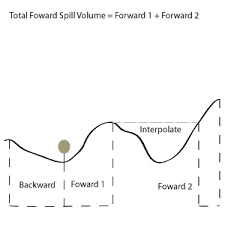

---



We want to code for a forward direction and a backward direction for each point. From there we will be able to add forward + backward spill volumes to find total spill volume. This will be re-itterative. 

Below, i start with a insanely large value as the variable last row and compare it to the current row. If it is smaller, then last row becomes that value. If it's large, that value is zero and we reiterate. 

In [44]:
%%time

df['Ele'] = df['Elevation'] #storing elevation for later use
df['Elevationbackward'] = df['Elevation'].values[::-1] #storing the backwards elevation for later use
df['distance between points backwards'] = df['distance between points'].values[::-1] #storing the distance between points for later use
df['solution backwards'] = df['distance between points backwards'] #creating a table of equal length to store data
 
df['distance between points 2'] = df['distance between points'] 
df['solution'] = df['distance between points']
df['Elevation 1'] = df['Elevation'] 
 
numberrows = len(df.index)
ii = 0
 
while ii < numberrows :
  
  df['Elevation 1']=df.Elevation.where(df.Elevation.eq(df.Elevation.cummax()),0) #cummulative max with zero replacement if not the max
  df['distance between points 2'] = np.where(df['Elevation 1'] == 0, 0, df['distance between points 2']) #where there are zeros, turn the dustance between points to zero
  df.loc[ii,'solution'] = df['distance between points 2'].sum() #sum the row
  df.loc[ii,'Elevation'] = 0 #replace the current elevation with a zero to move forward 
  df['Elevation 1'] = df['Elevation'] #replace elevation 1
  df['distance between points 2'] = df['distance between points'] #replace the distance between points with a fresh row
  ii = ii+1 #counter



CPU times: user 1.93 s, sys: 3.93 ms, total: 1.93 s
Wall time: 1.93 s


Here is now the backward spill volume that was defined before but was not iterated on. Here I do the same calc as before but instead of going forward I am going backward. 

In [45]:
%%time

ii = 0
 
while ii < numberrows :
  
  df['Elevation 1']=df.Elevationbackward.where(df.Elevationbackward.eq(df.Elevationbackward.cummax()),0)
  df['distance between points 2'] = np.where(df['Elevation 1'] == 0, 0, df['distance between points 2'])
  df.loc[ii,'solution backwards'] = df['distance between points 2'].sum()
  df.loc[ii,'Elevationbackward'] = 0
  df['Elevation 1'] = df['Elevationbackward'] 
  df['distance between points 2'] = df['distance between points']
  ii = ii+1

CPU times: user 1.95 s, sys: 4.96 ms, total: 1.95 s
Wall time: 1.95 s


Below I reverse the backwards solution to be able to once again add it to the forward solution for spill volume. 

In [46]:
%%time

df['solution backwards'] = df['solution backwards'].values[::-1]
df['total'] = df['solution backwards'] + df['solution']


CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.89 ms


Add the final plot to show the old elevation (set to Ele) and the spill volume totals that are the foward spill + backward spill volume here. 

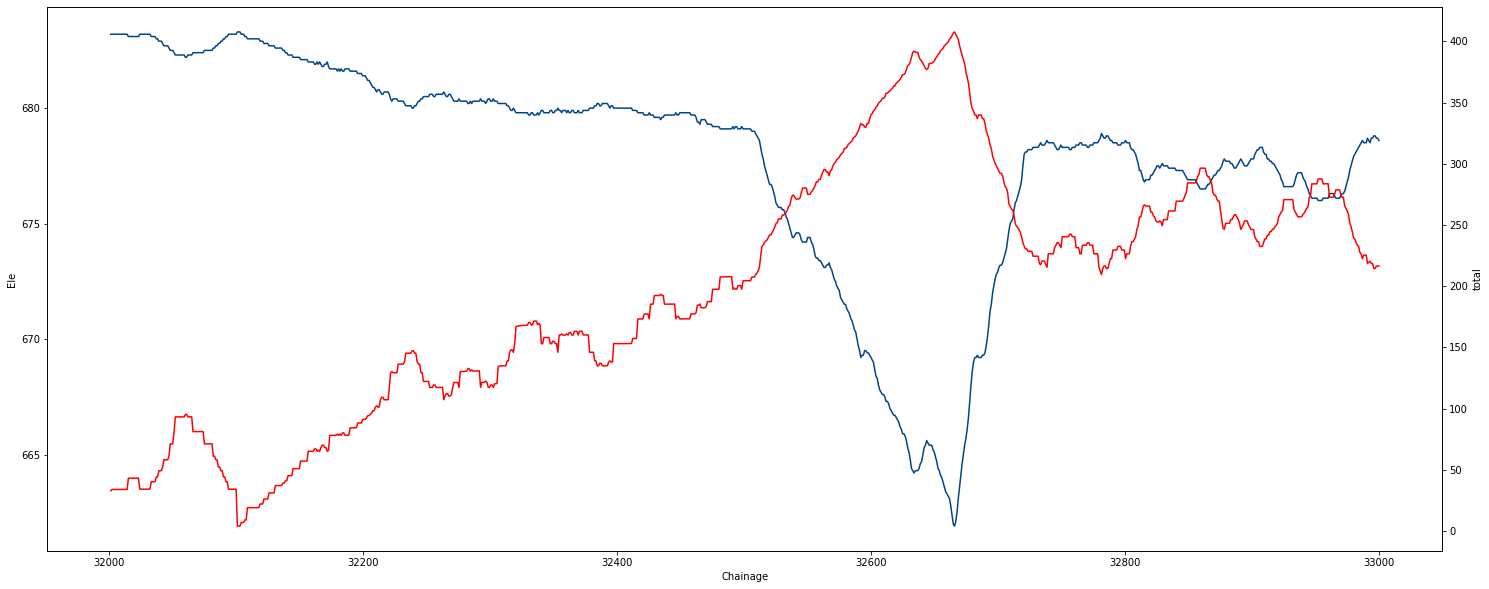

In [47]:
fig, ax1 = plt.subplots(figsize=(25,10))
ax2 = ax1.twinx()

sns.lineplot(x="Chainage", y="Ele", data=df, ax=ax1, color='#004488')
#sns.lineplot(x="Chainage", y="solution", data=df, ax=ax2, color='g')
#sns.lineplot(x="Chainage", y="solution backwards", data=df, ax=ax2, color='g')
sns.lineplot(x="Chainage", y="total", data=df, ax=ax2, color='r')



In [48]:
print(len(df))

1002
